# PROYECTO: ALZHEIMER ---> ENSAMBLADO DE DATOS
---

#  0. Librerias e Inicialización

In [1]:
# Librerias específicas de Tratamiento de imágenes RMI y fRMI
import nibabel as nib


In [2]:
# Librerias de Sistema
import os
import time

# Gestión de imágenes y Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# Pandas
import pandas as pd

# Numpy
import numpy as np

# Librerías Torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import  DataLoader, Dataset, Subset

# Librerías Utilidades para Torch
from torchinfo import summary

# Librerias de Scikit-Learn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from functools import reduce


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def mem_stats():
    mem = torch.cuda.memory_allocated() / (1024 ** 2)
    peak = torch.cuda.max_memory_allocated() / (1024 ** 2)
    mem_reserved = torch.cuda.memory_reserved() / (1024 ** 2) 
    print('Torch Version:', torch.__version__)
    print('Device:', torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    print(f"GPU Memory -->  Usage: {mem:.2f} MB | Peak: {peak:.2f} MB| Reserved: {mem_reserved:.2f} MB")

mem_stats()

Torch Version: 2.5.1
Device: cuda
GPU Memory -->  Usage: 0.00 MB | Peak: 0.00 MB| Reserved: 0.00 MB


# 1. Datasets
---

## 1.1. Dataset Machine Learning

In [4]:
base_path   = './'
ML_datafile = 'df_final.csv'
filename = os.path.join(base_path, ML_datafile)
if os.path.exists(filename):
    df_ML = pd.read_csv(filename)
    print(f"Archivo de datos cargado correctamente: {filename} --> Shape: {df_ML.shape}")
    display(df_ML.head())  
else:
    print("No se encontró el archivo:",ML_datafile)

df_features = df_ML.drop(columns = ['S#','hoja','target'])
df_target = df_ML[['target']]
print(df_ML.shape, df_features.shape, df_target.shape)

Archivo de datos cargado correctamente: ./df_final.csv --> Shape: (1006, 65)


,S#,hoja,RavenAccE20_A1,RavenAccM20_A1,RavenAccH20_A1,RavenAccAll20_A1,RavenNumCor20_A1,RavenNumAnswer20_A1,EtsLsP1_21_A1,EtsLsP2_21_A1,...,EduYrsEstCap5_A6,HopImmRcll15_A2,HopDelayRcll15_A2,HopRcgCrrct15_A2,HopRcgHit15_A2,HopRcgFaRelat15_A2,HopRcgFaUnrelat15_A2,HopRcgFaTotal15_A2,HopRcgHitminusfa15_A2,target
0,12,1,-4.097357,-3.221361,-2.154725,-3.427820,-3.365083,-4.477502,-0.398050,0.550592,...,0.881903,-0.353037,-1.747236,-3.930217,-3.218623,-0.867302,-0.465984,-0.867301,-2.569956,30
1,12,2,0.470741,0.814204,1.015938,0.888059,0.924323,0.276029,0.951136,1.128997,...,1.064210,0.618660,1.113752,0.782784,0.727453,-0.867302,-0.465984,-0.867301,1.087340,30
2,12,3,-0.292132,0.140264,0.262226,-0.049001,-0.008157,0.276029,-0.060754,0.261389,...,-2.581921,-0.353037,-1.031989,-0.036868,0.009985,-0.867302,2.473072,0.528707,-0.242586,30
3,21,1,-4.097357,-3.221361,-2.154725,-3.427820,-3.365083,-4.477502,-0.937725,-1.618428,...,0.699597,0.132812,-1.747236,-3.930217,-3.218623,-0.867302,-0.465984,-0.867301,-2.569956,29
4,49,1,-4.097357,-3.221361,-2.154725,-3.427820,-3.365083,-4.477502,-0.600428,0.767494,...,-0.394242,-0.353037,-1.747236,-3.930217,-3.218623,-0.867302,-0.465984,-0.867301,-2.569956,27


(1006, 65) (1006, 62) (1006, 1)


## 1.2. Dataset DeepLearning

### 1.2.1. Clase Dataset

In [5]:

class CustomNIIDataset(Dataset):
    def __init__(self, 
                 device, 
                 path_base, 
                 path_filedata, 
                 binaria = True,
                 transform = None, 
                 output_shape = (128, 128, 128),
                 filter_target = None,
                 arquitecture = 'CNN',
                 segment = False,
                 segment_base = (0,0,0),
                 segment_size = 16,
                 data_memory = False
                ):
        self.path_base   = path_base
        self.df_targets = pd.read_csv(path_filedata)
        self.transform  = transform
        self.binaria = binaria
        self.filter_target = filter_target
        self.arquitecture = arquitecture
        self.segment = segment
        self.segment_base = segment_base
        self.segment_size = segment_size
        self.data_memory = data_memory
        # Cargar todos los paths
        self._all_paths = []
        self._all_targets = []
        self._all_types = []
        self._all_ID = []
        self._all_hoja = []

        self._load_all_samples()

        # Inicialización: dataset sin filtrar
        self.output_shape = output_shape  # ( H, W, D)
        self.device = device
        
    def _load_all_samples(self):
        n_subjects = 0
        n_seasons = 0    
        n_samples = 0
        n_samples_added = 0
        n_error = 0
        for subj in os.listdir(self.path_base):
            subj_path = os.path.join(self.path_base, subj)
            if not os.path.isdir(subj_path):
                continue

            try:
                subj_num = int(subj.split('-')[1])
            except:
                continue
            
            targets_min = self.df_targets['target'].min()
            n_subjects += 1
            for ses in os.listdir(subj_path):
                n_seasons += 1
                ses_path = os.path.join(subj_path, ses)
                if not os.path.isdir(ses_path):
                    continue

                try:
                    hoja_num = int(ses.split('wave')[1])
                except:
                    continue

                mask = (self.df_targets['S#'] == subj_num) & (self.df_targets['hoja'] == hoja_num)
                if mask.sum() == 0:
                    #print('Warning: No target found for this sample:', ses_path) 
                    n_error +=1
                    continue
                                
                targets = self.df_targets.loc[mask, 'target'].values
                if (len(targets)>0):
                    target = targets[0]
                    if (self.filter_target is not None and target in self.filter_target):
                        add_sample = False
                    else:
                        add_sample = True
                    target = target - targets_min
                    if self.binaria:
                        # Binarizar target
                        target = 1 if target < 3 else 0

                for tipo in os.listdir(ses_path):
                    tipo_path = os.path.join(ses_path, tipo)
                    if not os.path.isdir(tipo_path):
                        continue

                    for fname in os.listdir(tipo_path):
                        if fname.endswith('.nii') or fname.endswith('.nii.gz'):
                            n_samples +=1
                            if add_sample:
                                n_samples_added += 1
                                path = os.path.join(tipo_path, fname)
                                self._all_paths.append(path)
                                self._all_targets.append(target)
                                self._all_types.append(tipo)
                                self._all_ID.append(subj_num)
                                self._all_hoja.append(hoja_num)
        
        print('\nTotal Pacientes en la base de Datos:    ', n_subjects, ' (Seasons =',n_seasons,')')
        print('Muestras Descartadas por falta de Target: ', n_error)
        print('Total Muestras en la base de datos:       ', n_samples)
        if self.filter_target is not None:
            print('--> Dataset Filtrado por Targets Eliminados=', self.filter_target,':',n_samples_added, 'muestras')
   
    def filter_clase(self, clase):
        """Filtra self.paths conservando solo aquellos cuyo nombre de archivo contiene la clase de archivo"""
        indices_filtrados = [
                               i for i, path in enumerate(self.paths) if clase in os.path.basename(path)
                          ]
        
        self.paths   = [self.paths[i] for i in indices_filtrados]
        self.targets = [self.targets[i] for i in indices_filtrados]
        self.types   = [self.types[i] for i in indices_filtrados]
        self.ID      = [self.ID[i] for i in indices_filtrados]
        self.hoja    = [self.hoja[i] for i in indices_filtrados]
        print(f'--> Dataset filtrado por clase="{clase}": {len(self.paths)} muestras.')
        
    def filter_tipo(self, tipos):
        """Filtra el dataset para incluir solo ciertos tipos (str o lista de str)"""
        if isinstance(tipos, str):
            tipos = [tipos]  # convertir a lista si es string único

        indices = [i for i, t in enumerate(self._all_types) if t in tipos]

        self.paths   = [self._all_paths[i] for i in indices]
        self.targets = [self._all_targets[i] for i in indices]
        self.types   = [self._all_types[i] for i in indices]
        self.ID      = [self._all_ID[i] for i in indices]
        self.hoja    = [self._all_hoja[i] for i in indices]
        
        print(f'--> Dataset filtrado por tipos={tipos}: {len(self.paths)} muestras.')

    def reset_filter(self):
        """Restaura el dataset completo (sin filtros)"""
        self.paths = list(self._all_paths)
        self.targets = list(self._all_targets)
        self.types = list(self._all_types)
        self.ID = list(self._all_ID)
        self.hoja = list(self._all_hoja)

        print(f'--> Filtro reseteado: {len(self.paths)} muestras activas.')


    def resize_or_pad(self, data):
        #data = torch.from_numpy(data).unsqueeze(0).float()  # [1, H, W, D]

        # Resize con interpolación si tamaño es diferente
        data = F.interpolate(data.unsqueeze(0), size=self.output_shape, mode='trilinear', align_corners=False)
        data = data.squeeze(0) 
        return data  # [1, D, H, W]

    def preload_all_to_gpu(self):
        """Carga todas las muestras en memoria GPU"""
        self._data_gpu = []
        mem = torch.cuda.memory_allocated() / (1024 ** 2)
        peak = torch.cuda.max_memory_allocated() / (1024 ** 2)
        mem_reserved = torch.cuda.memory_reserved() / (1024 ** 2) 
        print(f"GPU Memory Before -->  Usage: {mem:.2f} MB | Peak: {peak:.2f} MB| Reserved: {mem_reserved:.2f} MB")
        for idx in range(len(self.paths)):
            print('.', end='')
            path = self.paths[idx]
            try:
                nii_img = nib.load(path)
                data = nii_img.get_fdata(dtype=np.float32)
    
                # Normalización z-score
                data = (data - np.mean(data)) / (np.std(data) + 1e-8)
                data = torch.from_numpy(data).unsqueeze(0).float()
                
                if torch.isnan(data).any():
                    raise ValueError(f' El tensor contiene NaNs en el archivo: {path}')
                if torch.isinf(data).any():
                    raise ValueError(f' El tensor contiene Inf en el archivo: {path}')
            except:
                print('archivo corrupto:',path)
                path = self.paths[0]
                target = self.targets[0]
                tipo = self.types[0]
                nii_img = nib.load(path)
                data = nii_img.get_fdata(dtype=np.float32)
    
            sbase = [b * self.segment_size for b in self.segment_base]
            if self.segment:
                for ix, base in enumerate(sbase):
                    if (base + self.segment_size > data.shape[ix+1]):
                        sbase[ix] = data.shape[ix+1] - self.segment_size
                    if sbase[ix] < 0:
                        sbase[ix] = 0
                    
                W0, H0, D0 = sbase
                S = self.segment_size
                data = data[:,W0:W0+S, H0:H0+S, D0:D0+S]
            self._data_gpu.append(data) 

        self._data_gpu = torch.stack(self._data_gpu).to(self.device)
        print('\nDatos cargados en Memoria:',len(self.paths))
        mem = torch.cuda.memory_allocated() / (1024 ** 2)
        peak = torch.cuda.max_memory_allocated() / (1024 ** 2)
        mem_reserved = torch.cuda.memory_reserved() / (1024 ** 2) 
        print(f"GPU Memory After -->  Usage: {mem:.2f} MB | Peak: {peak:.2f} MB| Reserved: {mem_reserved:.2f} MB")
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path   = self.paths[idx]
        target = self.targets[idx]
        tipo   = self.types[idx]
        ID     = self.ID[idx]
        hoja   = self.hoja[idx]

        if self.data_memory:
            data = self._data_gpu[idx]
        else:
            nii_img = nib.load(path)
            try:
                data = nii_img.get_fdata(dtype=np.float32)
                        # Normaliza a rango 0-1
                data = (data - np.mean(data)) / (np.std(data) + 1e-8)
                data = torch.from_numpy(data).unsqueeze(0).float()
                if torch.isnan(data).any():
                    raise ValueError(f' El tensor contiene NaNs en el archivo: {path}')
                if torch.isinf(data).any():
                    raise ValueError(f' El tensor contiene Inf en el archivo: {path}')
            except:
                print('archivo corrupto:',path)
                path = self.paths[0]
                target = self.targets[0]
                tipo = self.types[0]
                nii_img = nib.load(path)
                data = nii_img.get_fdata(dtype=np.float32)
    
            sbase = [b * self.segment_size for b in self.segment_base]
            if self.segment:
                for ix, base in enumerate(sbase):
                    if (base + self.segment_size > data.shape[ix+1]):
                        sbase[ix] = data.shape[ix+1] - self.segment_size
                    if sbase[ix] < 0:
                        sbase[ix] = 0
                    
                W0, H0, D0 = sbase
                S = self.segment_size
                data = data[:,W0:W0+S, H0:H0+S, D0:D0+S]
            data = data.to(self.device)
        if self.arquitecture == 'CNN'  or self.arquitecture == 'VIT':
            if len(data.shape) == 5: 
                #data = data[:,:,:,:,data.shape[-1]/2]
                #data = data.mean(-1)
                rand = np.random.randint(0, data.shape[-1])
                data = data[:,:,:,:,rand]
            if self.output_shape is not None:
                data = data[:,:self.output_shape[0],:self.output_shape[1], :]
                # Resize/Padding a tamaño uniforme
                #data = self.resize_or_pad(data)
                if self.output_shape[2] - data.shape[3]> 0:
                    data = F.pad(data, (0, self.output_shape[2] - data.shape[3])) 
                if self.output_shape[2] - data.shape[3] < 0:
                    data = data[:,:,:,:self.output_shape[2]]
            
        if self.transform:
            data = self.transform(data)
        
        
        target = torch.tensor(target, dtype=torch.long).to(self.device)
        
        return data, target, tipo, ID, hoja


In [6]:
def build_Datasets(dataset_config, split_config):

    # -------- Crea el Dataset Con Todas las Muestras en Path Base --------
    dataset = CustomNIIDataset(**dataset_config)
    # -------- Filtra las muestras y se queda solo con las muestras --------
    # -------- de la/s carpeta/s en FilterData --------
    if split_config['filter_tipo'] is not None:
        dataset.filter_tipo(split_config['filter_tipo'])
    else:
        dataset.reset_filter()
    if split_config['filter_clase'] is not None:
        dataset.filter_clase(split_config['filter_clase'])

    if split_config['dataset_demo']:
        dataset = Subset(dataset, list(range(split_config['dataset_demosize'])))
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
        print('Demo Mode. Total de Muestras:',len(targets))
    else:
        targets = dataset.targets

    if dataset_config['data_memory']:
        dataset.preload_all_to_gpu()
    
    print(f"Dataset Global: {len(dataset)}")
    print('Dimensiones de las muestras: ',list(next(iter(dataset))[0].shape))

    return dataset, targets
    



In [7]:
# PARAMETROS DATASET
NUM_CLASSES = 1 # len(np.unique(targets))
ARQUITECTURE = 'CNN'
DATASET_CONFIG = {
    "device": DEVICE,
    "path_base": r"C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0",
    #"path_base": r"V:\\Datasets\\Dallas\\processed",
    #"path_base": r"V:\Datasets\Dallas\ds004856-1.2.0",
    #"path_base": r"G:\Mi unidad\04.Datasets\Dallas\ds004856-1.2.0",
    "path_filedata": 'DatosCompletos.csv',
    "binaria": True,
    "transform": None,  
    "output_shape":  None, # (128, 128, 111),   # Original: (512, 512, 64)  #Preprocesado: (197, 233, 189)   (512, 512, 64) 
    # Bold: (64, 64, 43, 211) -->
    # func: [1, 64, 64, 43, 154] --> [154, 176128] (RNN)
    "filter_target": [27,28,29 ], 
    "arquitecture" : ARQUITECTURE, # 'CNN', 'RNN', 'RAW'
    'segment'      : True,
    'segment_base' : [2,2,2],
    'segment_size' : 8,
    'data_memory'  : False

}
SPLIT_CONFIG = {
    "filter_tipo":  ['func'],
    "filter_clase": 'VentralVisual', #'Scene', #'FLAIR'
    "dataset_demo": False,
    "dataset_demosize": 32,
    "split": (0.8, 0.15),
    "seed": 42
}
print('\nPath Dataset:', DATASET_CONFIG['path_base'])
print('File Data:', DATASET_CONFIG['path_filedata'],'\n')

dataset, targets = build_Datasets(DATASET_CONFIG, SPLIT_CONFIG)



Path Dataset: C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0
File Data: DatosCompletos.csv 


Total Pacientes en la base de Datos:     464  (Seasons = 969 )
Muestras Descartadas por falta de Target:  15
Total Muestras en la base de datos:        11053
--> Dataset Filtrado por Targets Eliminados= [27, 28, 29] : 4863 muestras
--> Dataset filtrado por tipos=['func']: 3000 muestras.
--> Dataset filtrado por clase="VentralVisual": 448 muestras.
Dataset Global: 448
Dimensiones de las muestras:  [1, 8, 8, 8]


# 2. Modelos

## 2.1. Modelo Machine Learning


In [8]:
# Carga el modelo desde el archivo pkl
model_ML = [] 

model_ml_file = ['best_model_clasifier_RF.pkl', 'best_model_clasifier_neural_net.pkl',  'best_model_clasifier_gradient_boosting.pkl']
for file in model_ml_file: 
    print(file)
    model_save = joblib.load(file)
    model_ML.append(model_save['model'])
features = df_features[model_save['features']]


best_model_clasifier_RF.pkl
best_model_clasifier_neural_net.pkl
best_model_clasifier_gradient_boosting.pkl


## 2.2. Modelos DeepLearning

### 2.2.1. Definición del modelo CNN 3D


In [14]:
class SEBlock3D(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock3D, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, d, h, w = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1, 1)
        return x * y

In [15]:

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dropout=0.3):
        super(ResidualBlock3D, self).__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.act1 = nn.GELU()

        self.dropout = nn.Dropout3d(dropout)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Skip connection (con ajuste si hay cambio de canales o stride)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

        self.final_act = nn.GELU()

    def forward(self, x):
        #residual = self.shortcut(x)
        #residual = x 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        #out += residual
        return self.final_act(out)

In [16]:
class CNN3DModel(nn.Module):
    def __init__(self, 
                 input_channels=1,
                 n_blocks=4,
                 kernel_size=3,
                 n_kernel_base=16,
                 dropout=0.3,
                 num_classes=2,
                 attention = False):
        super(CNN3DModel, self).__init__()

        self.blocks = nn.Sequential()
        current_channels = input_channels

        for i in range(n_blocks):
            out_channels = n_kernel_base * (2 ** i)
            stride = 2 #if i == 0 else 1  # Reducción de resolución solo al inicio
            res_block = ResidualBlock3D(current_channels, out_channels, kernel_size=kernel_size, stride=stride, dropout=dropout)
            if attention:
                se_block = SEBlock3D(out_channels)
                self.blocks.append(nn.Sequential(res_block, se_block))
            else:
                self.blocks.append(res_block)
            
            current_channels = out_channels

        # Para Grad-CAM, guardamos explícitamente la última convolución
        self.last_conv = nn.Conv3d(current_channels, current_channels, kernel_size=3, padding=1, bias=False)
        self.last_bn = nn.InstanceNorm3d(current_channels,  affine=True) #GroupNorm(num_groups=8, num_channels=current_channels)
        self.last_act = nn.GELU()
        self.adaptive_pool = nn.AdaptiveAvgPool3d(output_size=(2, 2, 2))

        self.classifier = nn.Sequential(
            nn.Linear(current_channels * 2**3, 256 ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear( 256, 64 ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(64 , num_classes)
        )

    def forward(self, x):
        if (len(x.shape)==5):
            x = x[:,:,:,:,:64]
        for block in self.blocks:
            x = block(x)
            
        x = self.last_conv(x)
        x = self.last_bn(x)
        x = self.last_act(x)
        x = self.adaptive_pool(x)  # [B, C, 1, 1, 1]
        x = torch.flatten(x, 1)    # [B, C]
        x = self.classifier(x)
        return x

### 2.2.2. Modelo RNN

In [17]:
class RNN3DModel(nn.Module):
    def __init__(self, 
                 input_shape=176128,
                 reduced_size=256,
                 hidden_size=128, 
                 num_layers=1, 
                 rnn_type='LSTM', 
                 rnn_pixel = True,
                 rnn_reducer = False,
                 bidirectional=True, 
                 dropout=0.3,
                 num_classes = 1
                ):
        super().__init__()
        self.rnn_reducer = rnn_reducer
        self.rnn_pixel = rnn_pixel
        if rnn_pixel:
            self.input_shape = 1
        else:
            self.input_shape = input_shape

        if self.rnn_reducer:
            # Reducción de la dimensión espacial
            self.reducer = nn.Sequential(
                nn.Linear(input_size, 2048),  # (B, T, V) -> (B, T, D)
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(2048, 512),  # (B, T, V) -> (B, T, D)
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, reduced_size),  # (B, T, V) -> (B, T, D)
                nn.ReLU(),
                nn.Dropout(0.3)
            )
        
        rnn_cls = nn.LSTM if rnn_type == 'LSTM' else nn.GRU
        
        self.rnn = rnn_cls(
            input_size    = input_shape,
            hidden_size   = hidden_size,
            num_layers    = num_layers,
            bidirectional = bidirectional,
            dropout       = dropout if num_layers > 1 else 0,
            batch_first   = True
        )
        
        rnn_out_size = hidden_size * (2 if bidirectional else 1)
        
        self.classifier = nn.Sequential(
            nn.Linear(rnn_out_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),  # Binary classification
            #nn.Sigmoid()
        )

    def forward(self, x):  # x: (B,C,H,W,D,T)
        x = x.reshape( x.shape[0], -1, x.shape[-1]).permute(0,2,1)[:128,:] 
        # x: (B,C*H*W*D,T) = (B, V, T)      V:= C*H*W*D
        
        #print(x.shape)
        B, T, V = x.shape
        if self.rnn_reducer:
            x = self.reducer(x)  # → (B, T, V)  --> (B, T, V_reduced)
            B, T, V = x.shape
        if self.rnn_pixel:
              # Reorganizar: cada vóxel es una secuencia (por paciente)
            x = x.permute(0, 2, 1)      # (B, V, T)
            #print(x.shape)
            x = x.reshape(B * V, T, 1)  # (B*V, T, 1)
        #print(x.shape)
        output, _ = self.rnn(x)  # (T, num_voxels, hidden)
        #print(output.shape)
        last_step = output[:, -1, :]  # (B*V, hidden)
        #print(last_step.shape)
        if self.rnn_pixel:
            # Reconstruir batch y pool sobre vóxeles
            last_step = last_step.view(B, V, -1)  # (B, V, hidden)
            #print(last_step.shape)
            #global_rep = last_step.mean(dim=1)   # (B, hidden)  # (num_voxels, hidden)
            
            global_representation = last_step.mean(dim=1)  # (hidden,)
            
        else:
            global_representation = last_step
        #print(global_representation.shape)
        out = self.classifier(global_representation)
        #print(out.shape)
        return 1.0 - out

### 2.2.3. Transformer ViT 3D

In [18]:
def VIT3DModel(
        in_channels   = 1,
        img_size      = (64,64,43),
        patch_size    = (16,16,16),
        hidden_size   = 768,
        mlp_dim       = 3072,
        num_layers    = 12,
        num_heads     = 12,
        classification= True,
        num_classes   = 1,
        dropout       = 0.1,
        spatial_dims  = 3
        ):

    model = ViT(
        in_channels   = in_channels,
        img_size      = img_size,
        patch_size    = patch_size,
        hidden_size   = hidden_size,
        mlp_dim       = mlp_dim,
        num_layers    = num_layers,
        num_heads     = num_heads,
        classification= classification,
        num_classes   = num_classes,
        dropout_rate  = dropout,
        spatial_dims  = spatial_dims
    )
    return model

### 2.2.4. MONAI Transfer Learning 

In [19]:
class CNNClassifier(nn.Module):
    def __init__(self, in_channels, num_classes=1, dropout = 0.5):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool3d(2),  # Reduce spatial dims by 2

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            # AdaptiveAvgPool3D reduces to [B,64,1,1,1]
            nn.AdaptiveAvgPool3d(1)
        )
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [20]:
def MonaiModel_base(model_name = "brats_mri_segmentation", model_weights = None,dropout = None):
    #model = load_from_mmar(model_name)
    model = SwinUNETR(
        in_channels=1,
        out_channels=14,
        feature_size=48,
        use_checkpoint=True,
    )
    print('Modelo Inicializado:', model_name)
    if model_weights is not None:
        weight = torch.load(model_weights, weights_only=True)
        model.load_from(weights=weight)
        print('Pesos cargados en el modelo:',  model_weights)
        for param in model.parameters():
            param.requires_grad = False
        #for param in model.out.parameters():
        #    param.requires_grad = True
    return model    


In [21]:
class MonaiModel(nn.Module):
    def __init__(self, num_classes=1, model_name = "brats_mri_segmentation", model_weights = None,dropout = 0.0):
        super().__init__()
        self.segmentation_model = MonaiModel_base(model_name = model_name, model_weights = model_weights)
        self.classifier = CNNClassifier(in_channels=14, num_classes=num_classes, dropout = dropout)
        
    def forward(self, x):
        with torch.no_grad():
            seg_out = self.segmentation_model(x)  # [B,14,D,H,W]
        
        out = self.classifier(seg_out)
        return out


## 2.3. Carga de modelos DeepLearning

In [22]:
arquitecturas = ['VIT', 'CNN', 'RNN']
model_files  = [ 'best_model_VIT.pth', 'best_model_CNN_JUAN.pth', 'best_model_RNN_FINAL.pth']

models = {}
for arq, model_file in zip(arquitecturas, model_files):
    checkpoint = torch.load(model_file, weights_only=False, map_location='cpu')
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    models[arq] = model
    


# 3. Validación

## 3.1. Evaluación Machine Learning


### 3.1.0. Función de Validación

In [9]:
def validacion(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    
    try:
        auroc = roc_auc_score(y_test, y_pred)
    except:
        auroc = None
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Mostrar métricas
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Recall: {recall:.3f}")
    if auroc is not None:
        print(f"AUROC: {auroc:.3f}")
    else:
        print("AUROC: No disponible (verifica si es un problema binario).")
    
    # Matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Matriz de Confusión - Random Forest Optimizado")
    plt.show()
    
    def curva_auroc(y_test, y_pred):    
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        auroc = roc_auc_score(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('Curva ROC')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    curva_auroc(y_test, y_pred)

### 3.1.1. Archivo de Resultados de Machine Learning

       S#  hoja  y_pred  y_score  y_test
651  2031     1       0        0       0
107   252     1       0        0       0
299   823     2       0        0       0
128   327     1       0        0       0
230   615     1       1        1       1
381   976     1       0        0       0
170   466     3       0        0       0
616  1862     1       0        0       0
412  1031     1       0        0       0
993  4841     2       0        0       0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   S#       1006 non-null   int64
 1   hoja     1006 non-null   int64
 2   y_pred   1006 non-null   int32
 3   y_score  1006 non-null   int64
 4   y_test   1006 non-null   int64
dtypes: int32(1), int64(4)
memory usage: 35.5 KB
Accuracy: 0.994
Recall: 0.994
AUROC: 0.976


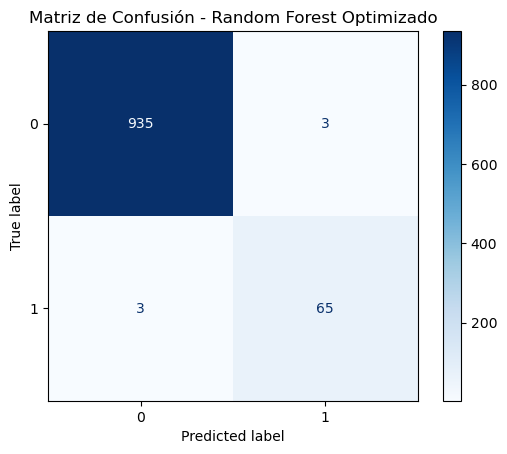

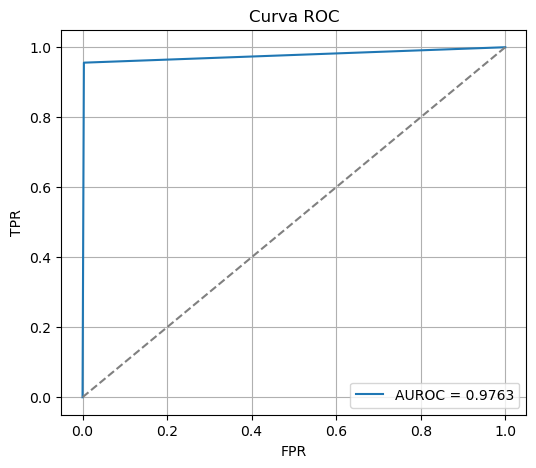

       S#  hoja  y_pred  y_score  y_test
591  1775     1       0        0       0
224   609     1       0        0       0
109   257     1       1        1       1
564  1615     3       0        0       0
59    169     2       0        0       0
854  3846     1       0        0       0
235   639     1       0        0       0
231   616     1       0        0       0
127   326     3       0        0       0
139   346     3       0        0       0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   S#       1006 non-null   int64
 1   hoja     1006 non-null   int64
 2   y_pred   1006 non-null   int64
 3   y_score  1006 non-null   int64
 4   y_test   1006 non-null   int64
dtypes: int64(5)
memory usage: 39.4 KB
Accuracy: 0.986
Recall: 0.986
AUROC: 0.993


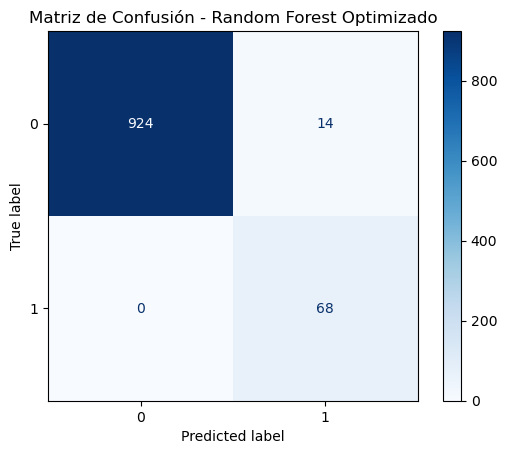

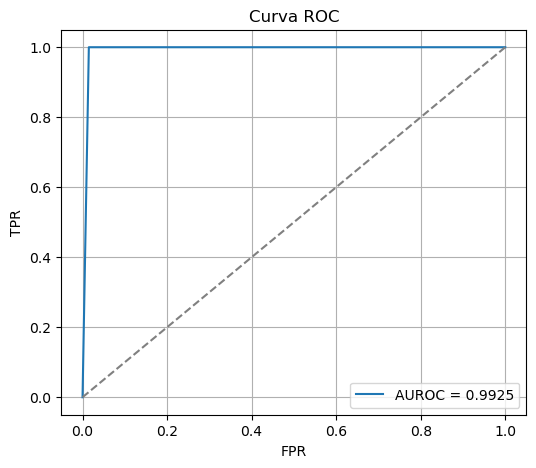

       S#  hoja  y_pred  y_score  y_test
402  1011     1       0        0       0
152   378     3       0        0       0
118   299     1       0        0       0
999  4868     3       0        0       0
405  1013     3       0        0       0
821  3571     1       0        0       0
554  1591     1       0        0       0
507  1356     2       0        0       0
3      21     1       1        1       0
301   829     1       0        0       0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   S#       1006 non-null   int64
 1   hoja     1006 non-null   int64
 2   y_pred   1006 non-null   int64
 3   y_score  1006 non-null   int64
 4   y_test   1006 non-null   int64
dtypes: int64(5)
memory usage: 39.4 KB
Accuracy: 0.977
Recall: 0.977
AUROC: 0.858


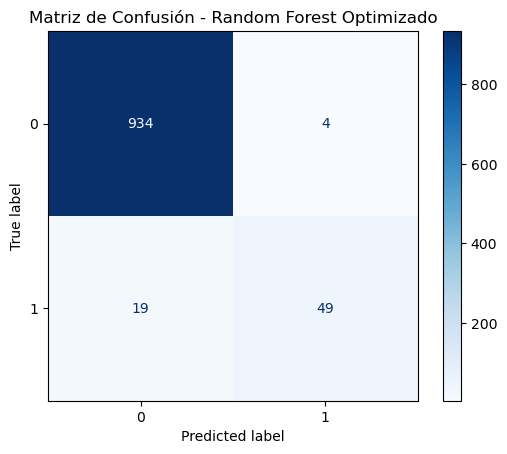

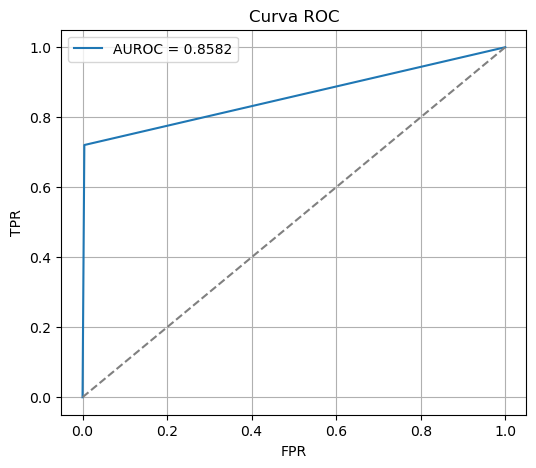

In [10]:
def resultados_ML(model_ml, nombre = None):
    y_pred = model_ml.predict(features)
    
    # Threshold si es clasificación
    threshold = 0.5
    
    # Crear la columna de clase_pred
    y_score = (y_pred >= threshold).astype(int)
    y_test = [0 if (x - df_ML['target'].min()) >2 else 1 for x in df_ML['target']]
    
    # Construir dataframe con las columnas requeridas
    df_results_ML = pd.DataFrame({
        'S#': df_ML['S#'].values,
        'hoja': df_ML['hoja'].values,
        'y_pred': y_pred,
        'y_score': y_score,
        'y_test': y_test
    })
    
    # Mostrar resultados
    print(df_results_ML.sample(10),'\n')
    df_results_ML.info()
    
    df_results_ML.to_csv(f'results_model_ML_{nombre}.csv', index = False)

    return df_results_ML

model_ml = ['rf', 'gb', 'nl']
for i,model in enumerate(model_ML):
    df_results_ML = resultados_ML(model, model_ml[i]) 
    validacion(df_results_ML['y_test'], df_results_ML['y_pred'])
    

### 3.1.2. Validación Machine Learning

## 3.2. Evaluación DeepLearning

### 3.2.0. Función de Validacion

In [25]:
def validate_model_DL(model, dataset, arquitecture = 'CNN', batch_size = 16, device = 'cpu', debug = True, save_path = None):
    
    model.to(device)
    model.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_probs = []
    all_targets = []
    all_outputs = []
    all_ID = []
    all_hoja = []
    
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    print('Numero de Batchs de Test:', len(test_loader))
    
    with torch.no_grad():
        for x, y, tipo, ID, hoja in test_loader:
            print('.',end='')
            x = x.unsqueeze(1).to(device) if x.dim() == 4 else x.to(device)
            y = y.to(device)
            if NUM_CLASSES == 1:
                if y.ndim == 2 and y.shape[1] > 1:
                    y = y.argmax(dim=1)  # solo si es one-hot
                y = y.float().unsqueeze(1)  # [B] → [B, 1]
            outputs = model(x)
            
            loss = criterion(outputs, y)
            test_loss += loss.item() * x.size(0)
            
            if NUM_CLASSES == 1:
                probs = torch.sigmoid(outputs)               # [B, 1]
                preds = (probs > 0.5).long()                # [B, 1]
                correct += (preds == y.long()).sum().item()
                total += y.size(0)
            else:
                _, predicted = outputs.max(1)
                correct += predicted.eq(y).sum().item()
                total += y.size(0)
                
                probs = torch.softmax(outputs, dim=1) 
                preds = torch.argmax(probs, dim=1) 

            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_targets.append(y.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
            all_ID.append(ID)
            all_hoja.append(hoja)
    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)
    y_score = np.concatenate(all_probs)
    y_ID = np.concatenate(all_ID)
    y_hoja = np.concatenate(all_hoja)
    outputs = np.concatenate(all_outputs)
        
    avg_loss = test_loss / total
    accuracy = correct / total
        
    class_report = classification_report(y_true, y_pred, zero_division=0, labels=list(range(2)))
    # Métricas
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # ROC y AUROC
    if NUM_CLASSES == 2:
         auroc = roc_auc_score(y_true, y_score[:, 1])
         fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
    else:
        probs = torch.sigmoid(torch.Tensor(outputs)).squeeze(1).cpu().numpy()  # [B]
        y_true = torch.Tensor(y_true).cpu().numpy()   
        auroc = roc_auc_score(y_true, probs)
        fpr, tpr, thresholds = roc_curve(y_true, probs)
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    if debug:
        print(class_report)
        print(f'\n Métricas de validación del Dataset Test:')
        print(f"Loss           : {avg_loss:.4f}")
        print(f'Accuracy       : {acc:.4f}')
        print(f'Precision      : {prec:.4f}')
        print(f'Recall         : {rec:.4f}')
        print(f'F1 Score       : {f1:.4f}')
        print(f'AUROC          : {auroc:.4f}')
        
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title("Matriz de Confusión")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()
    
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('Curva ROC')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    metrics =  {
        "Loss": avg_loss,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "auroc": auroc,
        "cm": cm
        }    
    #df_metrics = pd.DataFrame(metrics)
    #df_metrics.to_csv('metrics.csv')
    print(y_pred[:,0].shape, y_score[:,0].shape, y_true.shape)
    if save_path is not None:
        df_results_DL = pd.DataFrame({
                                'S#': y_ID,
                                'hoja': y_hoja,
                                'y_pred': y_pred[:,0],
                                'y_score': y_score[:,0],
                                'y_test': y_true[:,0]
                                }) 
        
        # Mostrar resultados
        print(df_results_DL.sample(10),'\n')
        df_results_DL.info()
        
        df_results_DL.to_csv(save_path, index = False)
        print('Resultados guardados como:', save_path )
       

    return metrics

### 3.2.1. Validacion

Arquitectura del Modelo: VIT 
 --------------------------------------------------

Total Pacientes en la base de Datos:     464  (Seasons = 970 )
Muestras Descartadas por falta de Target:  15
Total Muestras en la base de datos:        9764
--> Dataset Filtrado por Targets Eliminados= [27, 28, 29] : 4322 muestras
--> Dataset filtrado por tipos=['func']: 3000 muestras.
--> Dataset filtrado por clase="VentralVisual": 448 muestras.
Dataset Global: 448
Dimensiones de las muestras:  [1, 64, 64, 64]
Numero de Batchs de Test: 28
............................              precision    recall  f1-score   support

           0       0.84      1.00      0.92       378
           1       0.00      0.00      0.00        70

    accuracy                           0.84       448
   macro avg       0.42      0.50      0.46       448
weighted avg       0.71      0.84      0.77       448


 Métricas de validación del Dataset Test:
Loss           : 0.0000
Accuracy       : 0.8438
Precision      : 0.7119
Rec

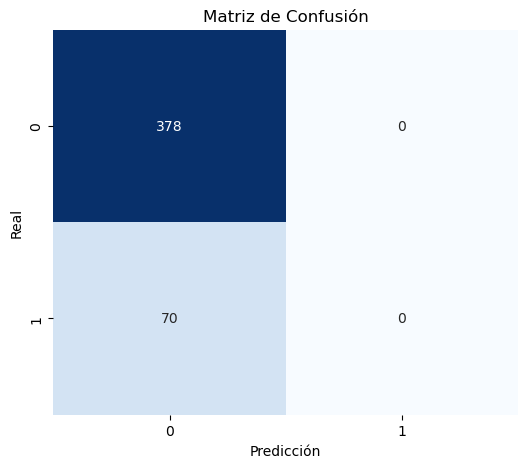

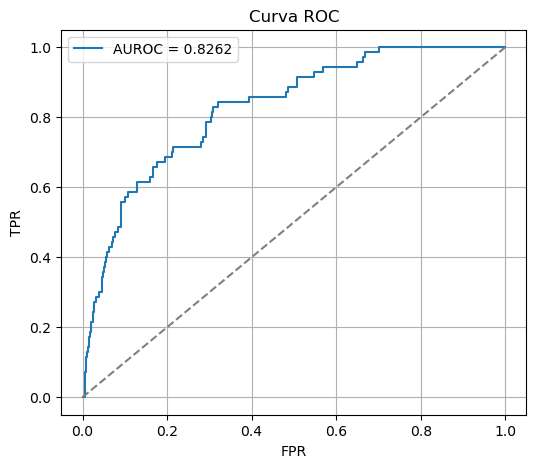

(448,) (448,) (448, 1)
       S#  hoja  y_pred   y_score  y_test
232  2206     2       0  0.015744     0.0
235  2210     1       0  0.005096     0.0
378   829     2       0  0.009010     0.0
140   164     2       0  0.014757     0.0
231   220     2       0  0.008153     0.0
80   1372     1       0  0.029010     1.0
318   599     1       0  0.014145     1.0
437   961     1       0  0.007866     0.0
313   567     2       0  0.010687     0.0
194  2031     2       0  0.011716     0.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S#       448 non-null    int64  
 1   hoja     448 non-null    int64  
 2   y_pred   448 non-null    int64  
 3   y_score  448 non-null    float32
 4   y_test   448 non-null    float32
dtypes: float32(2), int64(3)
memory usage: 14.1 KB
Resultados guardados como: results_model_DL_VIT.csv
Arquitectura del Modelo: CNN 
 ---------

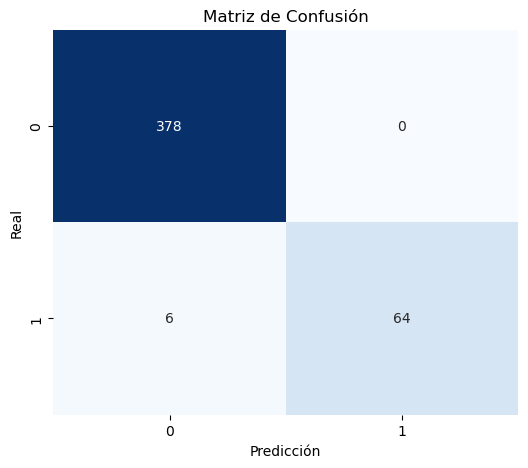

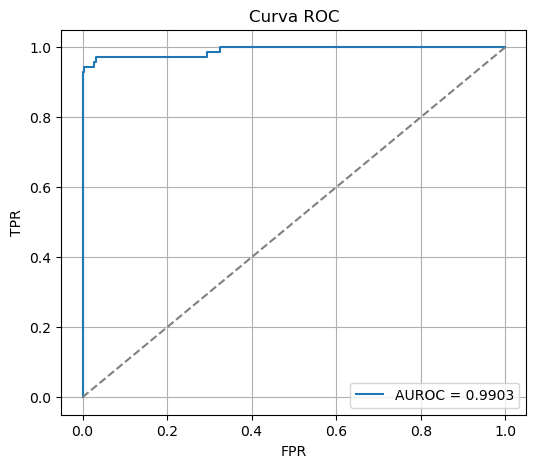

(448,) (448,) (448, 1)
       S#  hoja  y_pred   y_score  y_test
28   1124     2       0  0.000194     0.0
135  1615     2       0  0.000210     0.0
404   883     2       0  0.000466     0.0
88    139     2       0  0.000523     0.0
329   634     2       0  0.000234     0.0
201  2044     1       1  0.980010     1.0
407   884     1       0  0.000166     0.0
20   1054     2       0  0.008359     0.0
197  2035     1       1  0.974160     1.0
284   465     2       0  0.000199     0.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S#       448 non-null    int64  
 1   hoja     448 non-null    int64  
 2   y_pred   448 non-null    int64  
 3   y_score  448 non-null    float32
 4   y_test   448 non-null    float32
dtypes: float32(2), int64(3)
memory usage: 14.1 KB
Resultados guardados como: results_model_DL_CNN.csv
Arquitectura del Modelo: RNN 
 ---------

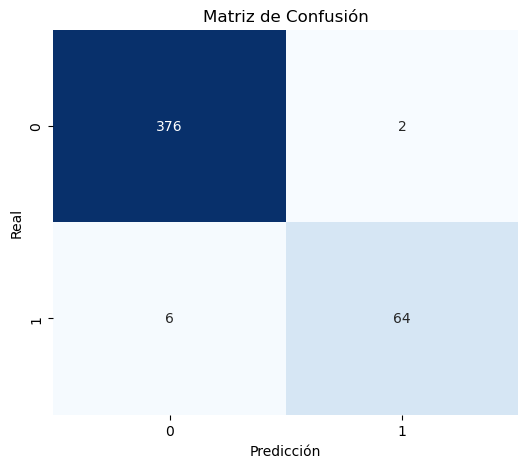

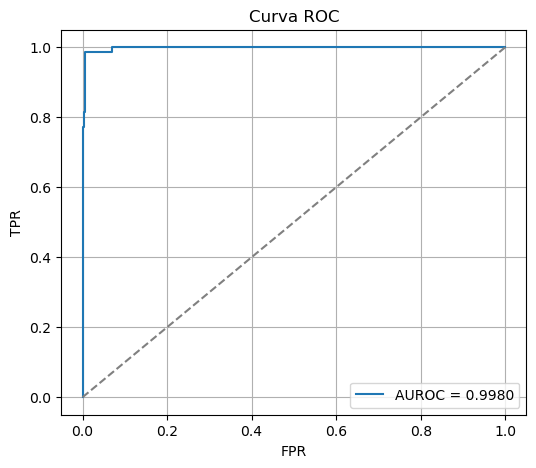

(448,) (448,) (448, 1)
       S#  hoja  y_pred   y_score  y_test
7    1022     1       0  0.000270     0.0
401   872     2       0  0.000802     0.0
420   898     2       0  0.000073     0.0
142  1656     2       0  0.000093     0.0
397   867     1       1  0.995719     1.0
109   147     1       0  0.000716     0.0
177  1850     2       0  0.000085     0.0
408   884     2       0  0.000076     0.0
33   1139     2       0  0.000112     0.0
375   819     1       0  0.038162     1.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S#       448 non-null    int64  
 1   hoja     448 non-null    int64  
 2   y_pred   448 non-null    int64  
 3   y_score  448 non-null    float32
 4   y_test   448 non-null    float32
dtypes: float32(2), int64(3)
memory usage: 14.1 KB
Resultados guardados como: results_model_DL_RNN.csv


In [26]:
for arq, model in models.items():
    print('Arquitectura del Modelo:', arq,'\n', '-'*50)
    DATASET_CONFIG['arquitecture']  = arq
    if arq == 'CNN':
        DATASET_CONFIG['segment']       = False
        DATASET_CONFIG['data_memory']   = False
        SPLIT_CONFIG['dataset_demo']    = False
        DATASET_CONFIG['output_shape']  = None
    if arq == 'RNN':
        DATASET_CONFIG['segment']       = True
        DATASET_CONFIG['segment_base']  = [4,6,3]
        DATASET_CONFIG['segment_size']  = 8
        DATASET_CONFIG['data_memory']   = True
        SPLIT_CONFIG['dataset_demo']    = False
        DATASET_CONFIG['output_shape']  = None
    if arq == 'VIT':
        DATASET_CONFIG['segment']       = False
        DATASET_CONFIG['data_memory']   = False
        SPLIT_CONFIG['dataset_demo']    = False
        DATASET_CONFIG['output_shape']  = [64,64,64]
    
    dataset, targets = build_Datasets(DATASET_CONFIG, SPLIT_CONFIG)
    
    metrics = validate_model_DL(model, 
                                dataset, 
                                arquitecture = arq,
                                device = DEVICE, 
                                save_path = f'results_model_DL_{arq}.csv')

In [14]:
df_files = ['results_model_DL_CNN', 'results_model_DL_RNN', 'results_model_DL_VIT']
for df_file in df_files:
    df = pd.read_csv(f'{df_file}.csv')
    df_mean = df.groupby(['S#', 'hoja'], as_index=False).mean()
    df_mean.to_csv(f'{df_file}.csv', index=False)
    print(df_mean.head())


   S#  hoja  y_pred   y_score  y_test
0  12     1     0.0  0.000173     0.0
1  12     2     0.0  0.000187     0.0
2  49     2     0.0  0.000268     0.0
3  61     1     0.0  0.000335     0.0
4  80     2     0.0  0.000278     0.0
   S#  hoja  y_pred   y_score  y_test
0  12     1     0.0  0.000092     0.0
1  12     2     0.0  0.000076     0.0
2  49     2     0.0  0.000083     0.0
3  61     1     0.0  0.000374     0.0
4  80     2     0.0  0.000108     0.0
   S#  hoja  y_pred   y_score  y_test
0  12     1     0.0  0.006443     0.0
1  12     2     0.0  0.005012     0.0
2  49     2     0.0  0.009278     0.0
3  61     1     0.0  0.011556     0.0
4  80     2     0.0  0.006544     0.0


# 4. Ensamblado de Datos

## 4.0. Preparación de los Datos

In [15]:
# Rutas de tus archivos CSV
csv_files = [f for f in os.listdir('./') if f.startswith('results_model')]
#csv_files = ['results_model_ML.csv', 'results_model_DL_CNN.csv', 'results_model_DL_RNN.csv', 'results_model_DL_VIT.csv']
print(csv_files)
# Leer todos los DataFrames en una lista
dfs = [pd.read_csv(f) for f in csv_files]

# Verificar consistencia de IDs y orden
for i, df in enumerate(dfs):
    print(f"Archivo {i}: {df.shape}")

# Unirlos en un único DataFrame por S# y hoja
# Renombrar columnas y_score para cada modelo
for idx, df in enumerate(dfs):
    df.rename(columns={
        'y_score': f'y_score_model_{idx+1}',
        'y_pred': f'y_pred_model_{idx+1}'
    }, inplace=True)

# Merge sucesivo por S# y hoja
df_ensemble = reduce(lambda left, right: pd.merge(left, right, on=['S#','hoja','y_test'], how='inner'), dfs)

# Mostrar muestra de la unión
print(df_ensemble.head())
print(df_ensemble.info())

['results_model_DL_CNN.csv', 'results_model_DL_RNN.csv', 'results_model_DL_VIT.csv', 'results_model_ML_gb.csv', 'results_model_ML_nl.csv', 'results_model_ML_rf.csv']
Archivo 0: (224, 5)
Archivo 1: (224, 5)
Archivo 2: (224, 5)
Archivo 3: (1006, 5)
Archivo 4: (1006, 5)
Archivo 5: (1006, 5)
   S#  hoja  y_pred_model_1  y_score_model_1  y_test  y_pred_model_2  \
0  12     1             0.0         0.000173     0.0             0.0   
1  12     2             0.0         0.000187     0.0             0.0   
2  49     2             0.0         0.000268     0.0             0.0   
3  61     1             0.0         0.000335     0.0             0.0   
4  80     2             0.0         0.000278     0.0             0.0   

   y_score_model_2  y_pred_model_3  y_score_model_3  y_pred_model_4  \
0         0.000092             0.0         0.006443               0   
1         0.000076             0.0         0.005012               0   
2         0.000083             0.0         0.009278              

## 4.1. Averaging (Soft)

In [16]:


# Calcular promedio de scores (soft voting)
score_cols = [col for col in df_ensemble.columns if 'y_score_model' in col]
df_ensemble['y_score_mean'] = df_ensemble[score_cols].mean(axis=1, skipna=True)

# Generar predicción final (threshold 0.5)
df_ensemble['y_pred_ensemble_avg'] = (df_ensemble['y_score_mean'] >= 0.5).astype(int)

# Mostrar resultados
print(df_ensemble[['S#', 'hoja', 'y_test', 'y_score_mean', 'y_pred_ensemble_avg']].head())

missing_all = df_ensemble[df_ensemble['y_score_mean'].isna()]
print("Muestras sin predicción en ningún modelo:", missing_all.shape[0])

   S#  hoja  y_test  y_score_mean  y_pred_ensemble_avg
0  12     1     0.0      0.001118                    0
1  12     2     0.0      0.000879                    0
2  49     2     0.0      0.001605                    0
3  61     1     0.0      0.002044                    0
4  80     2     0.0      0.001155                    0
Muestras sin predicción en ningún modelo: 0


Accuracy: 0.982
Recall: 0.982
AUROC: 0.943


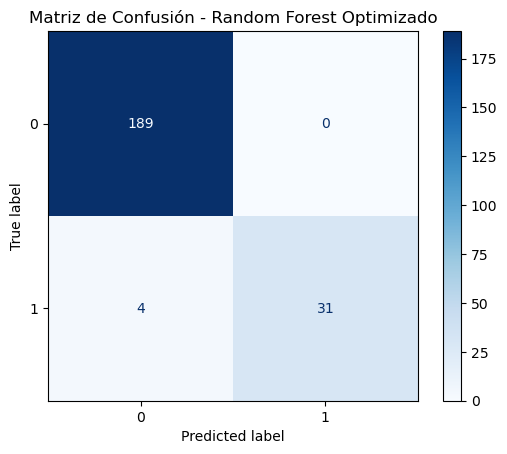

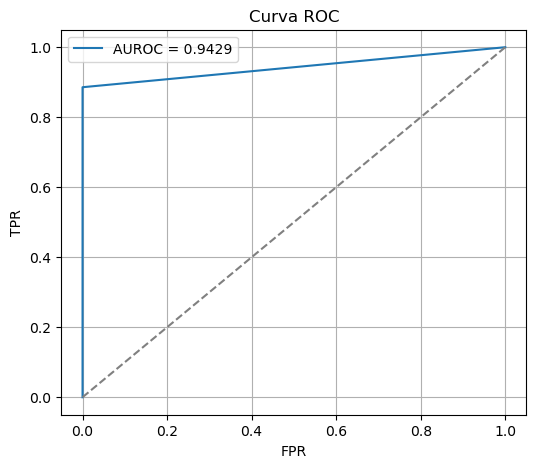

In [17]:
validacion(df_ensemble['y_test'], df_ensemble['y_pred_ensemble_avg'])

## 4.2. Voting (Hard)

In [18]:
pred_cols = [col for col in df_ensemble.columns if 'y_pred_model' in col]

# Reemplaza NaN por 0 o np.nan según preferencia
df_ensemble['votes_sum'] = df_ensemble[pred_cols].sum(axis=1, skipna=True)

# Número de votos no NaN
df_ensemble['votes_count'] = df_ensemble[pred_cols].notnull().sum(axis=1)

# Clase final: mayoría simple
df_ensemble['y_pred_ensemble_voting'] = (df_ensemble['votes_sum'] >= (df_ensemble['votes_count']/2)).astype(int)


Accuracy: 1.000
Recall: 1.000
AUROC: 1.000


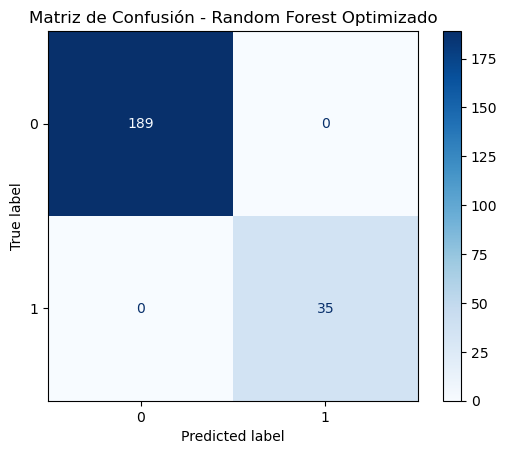

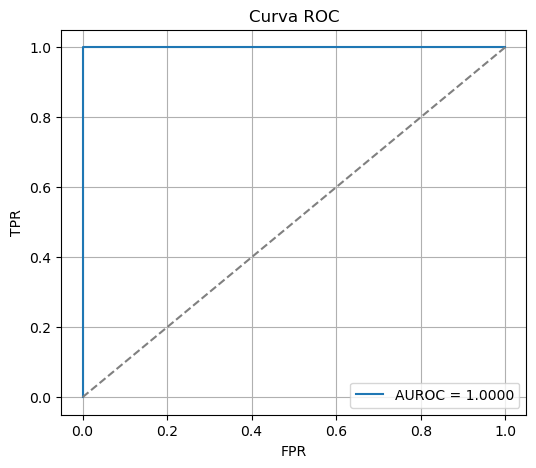

In [19]:
validacion(df_ensemble['y_test'], df_ensemble['y_pred_ensemble_voting'])

## 4.3. Stacking

In [20]:
# Features: las columnas y_score_model*
score_cols = [col for col in df_ensemble.columns if 'y_score_model' in col]

# Reemplazar NaN por un valor neutro (opcional: media global, mediana, o 0.5)
df_ensemble[score_cols] = df_ensemble[score_cols].fillna(0.5)

# X y y para el meta-modelo
X_stack = df_ensemble[score_cols].values
y_stack = df_ensemble['y_test'].values

In [21]:
meta_model = LogisticRegression()

# Entrenamiento simple
meta_model.fit(X_stack, y_stack)

# Predicciones
y_pred_stack_proba = meta_model.predict_proba(X_stack)[:,1]
y_pred_stack = (y_pred_stack_proba >= 0.5).astype(int)
df_ensemble['y_pred_ensemble_stacking'] = y_pred_stack
# Evaluación
auroc = roc_auc_score(y_stack, y_pred_stack_proba)
acc = accuracy_score(y_stack, y_pred_stack)

print(f"Stacking AUROC: {auroc:.4f}")
print(f"Stacking Accuracy: {acc:.4f}")

Stacking AUROC: 1.0000
Stacking Accuracy: 1.0000


Accuracy: 1.000
Recall: 1.000
AUROC: 1.000


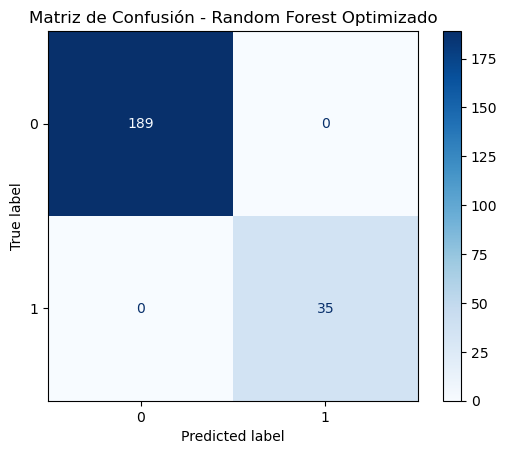

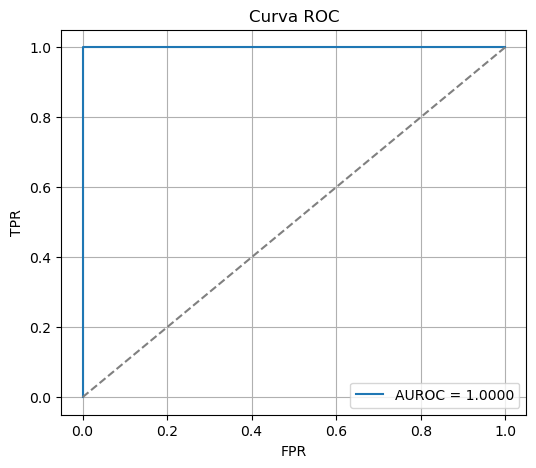

In [22]:
validacion(df_ensemble['y_test'], df_ensemble['y_pred_ensemble_stacking'])

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

meta_preds = np.zeros(len(y_stack))

for train_idx, test_idx in skf.split(X_stack, y_stack):
    X_train, X_test = X_stack[train_idx], X_stack[test_idx]
    y_train, y_test = y_stack[train_idx], y_stack[test_idx]
    
    meta_model = LogisticRegression()
    meta_model.fit(X_train, y_train)
    
    meta_preds[test_idx] = meta_model.predict_proba(X_test)[:,1]

# Evaluación final
auroc_cv = roc_auc_score(y_stack, meta_preds)
acc_cv = accuracy_score(y_stack, (meta_preds >= 0.5).astype(int))

print(f"Cross-validated stacking AUROC: {auroc_cv:.4f}")
print(f"Cross-validated stacking Accuracy: {acc_cv:.4f}")

Cross-validated stacking AUROC: 1.0000
Cross-validated stacking Accuracy: 1.0000


In [24]:
df_ensemble.info()
print('\n',df_ensemble.head())
df_ensemble.to_csv('Results_Ensemble.csv', index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   S#                        224 non-null    int64  
 1   hoja                      224 non-null    int64  
 2   y_pred_model_1            224 non-null    float64
 3   y_score_model_1           224 non-null    float64
 4   y_test                    224 non-null    float64
 5   y_pred_model_2            224 non-null    float64
 6   y_score_model_2           224 non-null    float64
 7   y_pred_model_3            224 non-null    float64
 8   y_score_model_3           224 non-null    float64
 9   y_pred_model_4            224 non-null    int64  
 10  y_score_model_4           224 non-null    int64  
 11  y_pred_model_5            224 non-null    int64  
 12  y_score_model_5           224 non-null    int64  
 13  y_pred_model_6            224 non-null    int64  
 14  y_score_mo

In [ ]:
j          